# Miniproject 3: Poem Generation

In [1]:
import requests

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


## RNN Code

In [2]:
from io import open
import glob
import os
import unicodedata
import string


training_lines_tmp = ""
with open('shakespeare.txt', 'r') as file:
    training_lines_tmp = file.read().splitlines()

def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

category_lines = {}
all_categories = []

training_lines_tmp = list(filter(lambda x: len(x) > 0, training_lines_tmp))


training_lines = ""
for i in range(len(training_lines_tmp)):
    #if i % 15 != 0:
    if has_numbers(training_lines_tmp[i]) == False:
        training_lines += training_lines_tmp[i]
        training_lines += "\n"

all_letters = ''.join(set(training_lines))
n_letters = len(all_letters)

In [3]:
print(training_lines)

From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed'st thy light's flame with self-substantial fuel,
Making a famine where abundance lies,
Thy self thy foe, to thy sweet self too cruel:
Thou that art now the world's fresh ornament,
And only herald to the gaudy spring,
Within thine own bud buriest thy content,
And tender churl mak'st waste in niggarding:
  Pity the world, or else this glutton be,
  To eat the world's due, by the grave and thee.
When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a tattered weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserved thy

In [4]:
all_letters

"!RFlwaCAfhO\nbx,yPq()ELcBJUzN':kjMGmYHo drnpvW-SgVu;IK.sD?iTet"

In [5]:
print(n_letters)
print(all_letters)

61
!RFlwaCAfhO
bx,yPq()ELcBJUzN':kjMGmYHo drnpvW-SgVu;IK.sD?iTet


In [6]:
import LSTM
import torch
import torch.nn as nn

import torch.optim as optim


In [7]:
import random

# Random item from a list
def randomChoice(l):
    sonnet_n = random.randint(0, int(len(l)) - 41)
    return l[sonnet_n:sonnet_n + 40], l[sonnet_n + 40]

# Get a random category and random line from that category
def randomTrainingLines():
    line1, line2 = randomChoice(training_lines)
    return line1, line2

In [8]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(0, len(line))]
    #letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)


In [9]:
rnn = LSTM.LSTM_S(n_letters, 200, n_letters)

In [10]:
line1, line2 = randomTrainingLines()
tmp = inputTensor(line1)
print(tmp.size())

torch.Size([40, 61])


In [11]:
def randomTrainingExample():
    line1, line2 = randomTrainingLines()
    input_line_tensor = inputTensor(line1)
    target_line_tensor = targetTensor(line2)
    return input_line_tensor, target_line_tensor

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(rnn.parameters())


learning_rate = 0.0001

def train(input_line_tensor, target_line_tensor):
    #target_line_tensor.unsqueeze_(-1)
    hn = rnn.initHidden()
    cn = rnn.initHidden()

    hn.squeeze_(-1)
    cn.squeeze_(-1)

    #print(hidden.size())
    #print(input_line_tensor[0].size())
    #print(target_line_tensor[0].size())

    optimizer.zero_grad()

    #for i in range(input_line_tensor.size(0)):
    output, hn, cn = rnn(input_line_tensor, hn, cn)
    #print(torch.sum(output))
    #print(output.size())
    #print(target_line_tensor.size())
    #print(target_line_tensor)
    loss = criterion(output, target_line_tensor)
    

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [13]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [14]:
print(n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    #print(torch.sum(output))
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

61
0m 52s (5000 5%) 0.0381
1m 45s (10000 10%) 0.0442
2m 38s (15000 15%) 0.0090
3m 28s (20000 20%) 0.0246
4m 19s (25000 25%) 0.0472
5m 9s (30000 30%) 0.0084
6m 2s (35000 35%) 0.0260
6m 51s (40000 40%) 0.0427
7m 43s (45000 45%) 0.0785
8m 33s (50000 50%) 0.0252
9m 22s (55000 55%) 0.0784
10m 11s (60000 60%) 0.0332
10m 59s (65000 65%) 0.0154
11m 47s (70000 70%) 0.0436
12m 36s (75000 75%) 0.0707
13m 24s (80000 80%) 0.0525
14m 12s (85000 85%) 0.0284
15m 0s (90000 90%) 0.0510
15m 50s (95000 95%) 0.0656
16m 38s (100000 100%) 0.0253


In [15]:
print(n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    #print(torch.sum(output))
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

61
0m 48s (5000 5%) 0.0175
1m 37s (10000 10%) 0.0155
2m 26s (15000 15%) 0.0438
3m 14s (20000 20%) 0.0001
4m 2s (25000 25%) 0.0342
4m 51s (30000 30%) 0.0315
5m 39s (35000 35%) 0.0257
6m 27s (40000 40%) 0.0423
7m 16s (45000 45%) 0.0771
8m 5s (50000 50%) 0.0377
8m 53s (55000 55%) 0.0201
9m 41s (60000 60%) 0.0507
10m 30s (65000 65%) 0.0363
11m 19s (70000 70%) 0.0039
12m 9s (75000 75%) 0.0465
12m 57s (80000 80%) 0.0896
13m 46s (85000 85%) 0.0712
14m 35s (90000 90%) 0.0200
15m 24s (95000 95%) 0.0255
16m 13s (100000 100%) 0.0226


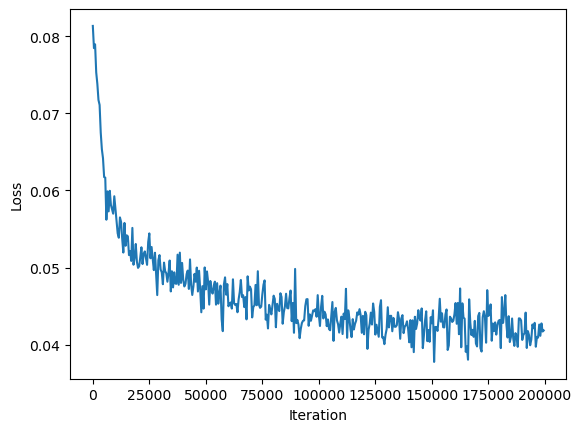

In [16]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(len(all_losses))*plot_every,all_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('loss.pdf')

In [19]:
import numpy as np
temperature = 0.75
max_length = 5000
def sample(start_seed):
    with torch.no_grad():  # no need to track history in sampling
        print(start_seed)
        input = inputTensor(start_seed)
        
        print(len(start_seed))
        print(input.size())

        

        hn = rnn.initHidden()
        cn = rnn.initHidden()

        output, hn, cn = rnn(input, hn, cn)

        output_name = start_seed

        for i in range(max_length):
            output, hn, cn = rnn(input, hn, cn)

            str = ""
            output_prob = torch.nn.Softmax()(output/temperature)
            output_idx = np.random.choice(range(n_letters), p=output_prob[0].numpy())
            str += all_letters[output_idx]
            output_name += str
            
            input = inputTensor(str)

        return output_name


seed = "shall i compare thee to a summer’s day?\n"
#seed = "Since that my life on thy revolt doth lie,"
print(len(seed))
print(len(seed))
tmp = inputTensor(seed)
print(tmp.size())
print(seed)
print(sample(seed))

40
40
torch.Size([40, 61])
shall i compare thee to a summer’s day?

shall i compare thee to a summer’s day?

40
torch.Size([40, 61])


/Users/weihou/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


shall i compare thee to a summer’s day?
  A carse repen me a do hone of then for alting hembly usure drace
done same that time will you and dow in thy prove love, but fremsee of halve green can pomer,
When that of thou true,
The deathly seem and up thee:
What loves, should shall vind, that me dost dore I to eyes of that wornd,
Who long to line me beauty should day cresent that her,
But doth wate,
  No then that uncore hember, no my time then adard face of youthed that I from one, in fanserts in that, not there mar,
For alt will, as a do imprite:
That my hourse with tend to my commower to me, when you are thou dost reme livity, not one,
But thy ward of anems call,
Are that when your gracely tweet loving that of even commised dough with self self ming, not life bost with age for the shalters have so the desing of to lovase,
While the ture my beauty of end other are be unseet for of ill.
Yet and foor me to dost doth not of hembs that even then willed fair the dest vily see so so be,
an is

In [47]:
temperature = 0.25
max_length = 5000
def sample(start_seed):
    with torch.no_grad():  # no need to track history in sampling
        print(start_seed)
        input = inputTensor(start_seed)
        
        print(len(start_seed))
        print(input.size())

        

        hn = rnn.initHidden()
        cn = rnn.initHidden()

        output, hn, cn = rnn(input, hn, cn)

        output_name = start_seed

        for i in range(max_length):
            output, hn, cn = rnn(input, hn, cn)

            str = ""
            output_prob = torch.nn.Softmax()(output/temperature)
            output_idx = np.random.choice(range(n_letters), p=output_prob[0].numpy())
            str += all_letters[output_idx]
            
            if (str == "\n"):
                output_name += "\\\\"
                output_name += str
            else:
                output_name += str
            input = inputTensor(str)

        return output_name


seed = "shall i compare thee to a summer’s day?\n"
#seed = "Since that my life on thy revolt doth lie,"
print(len(seed))
print(len(seed))
tmp = inputTensor(seed)
print(tmp.size())
print(seed)
print(sample(seed))

40
40
torch.Size([40, 61])
shall i compare thee to a summer’s day?

shall i compare thee to a summer’s day?

40
torch.Size([40, 61])


/Users/weihou/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


shall i compare thee to a summer’s day?
  And the some and of the see mand shall thought the sheet the state the treath so see,\\
So and thee,\\
That the sain,\\
The should your some thought the world the sain the some that the see to be love, in the some thought the to the way the best that thee the see better best the thee beauty the see,\\
And of the seet he the will that the mour best so more so to the some that the shall to the stant the show the will for the stall the with of the summer strive and the seess in the prove behand the should that the weep the see the are the best the to seem the will the time so should he sing the speep the see the mock the see the seem the sing.\\
  The seemed the with thee the strain some with the shall the live the love the show the see best be that the shall the shall that the state the oper with their moe and and the blows of the sain the should the beauty summer's becanse for the way the bright and the will my love to so the see make the state,